In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import os

filename = 'dataSet.csv'
if not os.path.exists(filename):
    from google.colab import files
    print(f"{filename} not found: please upload it now.")
    uploaded = files.upload()  # This will prompt upload if needed

df = pd.read_csv(filename)
print(df.head())


             Timestamp Year of Study Your Average Lecture attendance Rate  \
0  12/07/2025 16:50:00      3rd Year                            75% - 90%   
1  12/07/2025 16:50:29      3rd Year                            Above 90%   
2  12/07/2025 16:51:44      3rd Year                            Below 50%   
3  12/07/2025 16:51:49      3rd Year                            50% - 74%   
4  12/07/2025 16:55:43      2nd Year                            Above 90%   

  Recently Released Semester Results [Subject 1]  \
0                                             B+   
1                                             A-   
2                                             C-   
3                                              A   
4                                             B-   

  Recently Released Semester Results [Subject 2]  \
0                                             B+   
1                                             B+   
2                                              C   
3               

In [ ]:
# Drop unnecessary columns: Timestamp and extra subject columns (Subject 5 to 8)
columns_to_drop = [
    'Timestamp',
    'If you had more than four subjects [Subject 5]',
    'If you had more than four subjects [Subject 6]',
    'If you had more than four subjects [Subject 7]',
    'If you had more than four subjects [Subject 8]'
]
df = df.drop(columns=columns_to_drop)
print("Columns after drop:\n", df.columns)

Columns after drop:
 Index(['Year of Study', 'Your Average Lecture attendance Rate',
       'Recently Released Semester Results [Subject 1]',
       'Recently Released Semester Results [Subject 2]',
       'Recently Released Semester Results [Subject 3]',
       'Recently Released Semester Results [Subject 4]',
       'What is your current GPA ? (If you don't know, you can leave this)',
       'How many hours do you study per week?',
       'How Often do You Complete Assignments on Time',
       'Are you currently doing a part time job?',
       'If yes, how many hours per week do you work?',
       'Are you involved in any sports or extracurricular activities(clubs, societies, volunteering, etc.)?',
       'If yes, how many hours per week do you spend on sports  or extracurricular activities  ?'],
      dtype='object')


In [ ]:
# Handle and encode GPA column

gpa_col = "What is your current GPA ? (If you don't know, you can leave this)"
df[gpa_col] = pd.to_numeric(df[gpa_col], errors='coerce')                 # convert to numeric
df[gpa_col] = df[gpa_col].fillna(df[gpa_col].mean())                      # fill missing with mean

In [ ]:
# Drop rows with missing critical fields: Attendance and Subject 1 to 4 grades

subject_cols = [
    'Recently Released Semester Results [Subject 1]',
    'Recently Released Semester Results [Subject 2]',
    'Recently Released Semester Results [Subject 3]',
    'Recently Released Semester Results [Subject 4]'
]

df = df.dropna(subset=['Your Average Lecture attendance Rate'] + subject_cols)
print(f"Dataset shape after dropping rows with missing attendance or subject grades: {df.shape}")


Dataset shape after dropping rows with missing attendance or subject grades: (108, 13)


In [ ]:
# Encode Categorical Variables

# Encode Attendance Rate
attendance_map = {
    'Above 90%': 0.95,
    '75% - 90%': 0.825,
    '50% - 74%': 0.62,
    'Below 50%': 0.45
}
df['Attendance_Encoded'] = df['Your Average Lecture attendance Rate'].map(attendance_map)

# Encode Study Hours per week
study_hours_map = {
    'Less than 10 hours': 5,
    '10 hours - 20 hours': 15,
    'More than 20 hours': 25
}
df['StudyHours_Encoded'] = df['How many hours do you study per week?'].map(study_hours_map)

# Encode Assignment Completion Frequency
assignments_map = {
    'Always': 3,
    'Often': 2,
    'Sometimes': 1,
    'Rarely': 0
}
df['Assignments_Encoded'] = df['How Often do You Complete Assignments on Time'].map(assignments_map)

# Encode Part-Time Job and Extracurricular activities
df['PartTimeJob_Encoded'] = df['Are you currently doing a part time job?'].map({'Yes': 1, 'No': 0})
df['Extracurriculars_Encoded'] = df['Are you involved in any sports or extracurricular activities(clubs, societies, volunteering, etc.)?'].map({
    'Yes': 1,
    'No': 0,
    'Occasionally': 0.5
})


# Encode Grades for Subjects 1 to 4
grade_map = {
    'A+': 4.0, 'A': 4.0, 'A-': 3.7,
    'B+': 3.3, 'B': 3.0, 'B-': 2.7,
    'C+': 2.3, 'C': 2.0, 'C-': 1.7,
    'D+': 1.3, 'D': 1.0, 'E': 0.0,
    'Absent': np.nan, 'Ineligible': np.nan
}

for subj in subject_cols:
    encoded_col = subj.replace("Recently Released Semester Results ", "") + "_Encoded"
    df[encoded_col] = df[subj].map(grade_map)



In [ ]:
# Normalizing GPA

from sklearn.preprocessing import MinMaxScaler

gpa_col = "What is your current GPA ? (If you don't know, you can leave this)"
df[gpa_col] = pd.to_numeric(df[gpa_col], errors='coerce')
df[gpa_col] = df[gpa_col].fillna(df[gpa_col].mean())
scaler = MinMaxScaler()
df['GPA_Normalized'] = scaler.fit_transform(df[[gpa_col]])


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Fit the scaler on raw GPA (not the normalized one)
gpa_scaler = MinMaxScaler()
df['GPA_Normalized'] = gpa_scaler.fit_transform(df[[gpa_col]])


In [ ]:
# Create Target Variable as Average Grade of Subjects 1 to 4

encoded_subject_cols = [col.replace("Recently Released Semester Results ", "") + "_Encoded" for col in subject_cols]

df['Average_Grade'] = df[encoded_subject_cols].mean(axis=1)

# Drop rows where Average_Grade is NaN (if any subject grade was missing/unmapped)
df = df.dropna(subset=['Average_Grade'])
print(f"Data shape after dropping missing Average_Grade: {df.shape}")


Data shape after dropping missing Average_Grade: (108, 24)


In [ ]:
# Prepare Feature Matrix (X) and Target Vector (y)

features = [
    'Attendance_Encoded',
    'StudyHours_Encoded',
    'Assignments_Encoded',
    'PartTimeJob_Encoded',
    'Extracurriculars_Encoded',
    'GPA_Normalized'
]

target = 'Average_Grade'

X = df[features].values
y = df[target].values

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Feature matrix shape: (108, 6)
Target vector shape: (108,)


In [ ]:
# Normalizing Features

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
columns_to_save = features + [target]
df[columns_to_save].to_csv('preprocessed_model_data.csv', index=False)

#from google.colab import files
#files.download('preprocessed_model_data.csv')

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv('preprocessed_model_data.csv')
print(df.head())


   Attendance_Encoded  StudyHours_Encoded  Assignments_Encoded  \
0               0.825                15.0                    3   
1               0.950                 5.0                    3   
2               0.450                 5.0                    1   
3               0.620                15.0                    2   
4               0.950                 5.0                    3   

   PartTimeJob_Encoded  Extracurriculars_Encoded  GPA_Normalized  \
0                    1                       0.5        0.190909   
1                    0                       1.0        0.518182   
2                    1                       0.0        0.476348   
3                    0                       1.0        0.609091   
4                    0                       0.0        0.476348   

   Average_Grade  
0       3.300000  
1       2.925000  
2       1.233333  
3       3.000000  
4       1.900000  


In [ ]:
# Feature columns: all columns except the target
features = [col for col in df.columns if col != 'Average_Grade']
target = 'Average_Grade'

X = df[features].values
y = df[target].values


In [ ]:
print(np.isnan(X).sum(), np.isnan(y).sum())


1 0


In [ ]:
import numpy as np

# Create DataFrame for features and target to easily drop any NaNs at once
data = pd.DataFrame(X, columns=features)
data['Average_Grade'] = y
data = data.dropna()
X = data[features].values
y = data['Average_Grade'].values


In [ ]:
print(np.isfinite(X).all())
# Should print True

print(np.isnan(X).sum(), np.isnan(y).sum())
# Should both print 0


True
0 0


In [ ]:
df = df.dropna(subset=[target])


In [ ]:
keras.layers.Dense(1)  # no activation, defaults to 'linear'


<Dense name=dense, built=False>

In [ ]:
# 85% training, 15% testing (adjust split if you prefer)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)
print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")


Train shape: (90, 6), (90,)
Test shape: (17, 6), (17,)


In [ ]:
print(np.isnan(X_train).sum(), np.isnan(y_train).sum())
print(np.isinf(X_train).sum(), np.isinf(y_train).sum())
# all should print 0


0 0
0 0


In [ ]:
print(df[features + [target]].isnull().sum())


Attendance_Encoded          0
StudyHours_Encoded          1
Assignments_Encoded         0
PartTimeJob_Encoded         0
Extracurriculars_Encoded    0
GPA_Normalized              0
Average_Grade               0
dtype: int64


In [ ]:
df['StudyHours_Encoded'] = df['StudyHours_Encoded'].fillna(df['StudyHours_Encoded'].mean())


In [ ]:
print(df[features + [target]].isnull().sum())

Attendance_Encoded          0
StudyHours_Encoded          0
Assignments_Encoded         0
PartTimeJob_Encoded         0
Extracurriculars_Encoded    0
GPA_Normalized              0
Average_Grade               0
dtype: int64


In [ ]:
# Model Architecture1: Shallow MLP

model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1)
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Create EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',        # What to monitor (validation loss)
    patience=20,               # Number of epochs with no improvement after which training stops
    restore_best_weights=True  # Keeps the best weights (lowest val_loss)
)

# Then pass to model.fit() like this:
history = model.fit(
    X_train, y_train,
    epochs=200,                # Or any large number, training will usually stop earlier
    batch_size=20,
    validation_split=0.2,
    callbacks=[early_stop],    # Add the callback here
    verbose=1
)


Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 25.3327 - mae: 4.8751 - val_loss: 26.3718 - val_mae: 4.9598
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 19.9567 - mae: 4.3237 - val_loss: 21.5578 - val_mae: 4.4892
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 15.7848 - mae: 3.8852 - val_loss: 18.2785 - val_mae: 4.1389
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 13.9963 - mae: 3.6400 - val_loss: 15.3417 - val_mae: 3.7858
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 12.3475 - mae: 3.4300 - val_loss: 11.4357 - val_mae: 3.2638
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.4778 - mae: 3.0183 - val_loss: 8.4260 - val_mae: 2.7734
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.0207 - mae: 2.5750 - val_loss: 6.2168 - val_mae: 2.3192
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.4468 - mae: 2.2309 - val_loss: 4.6518 - val_mae: 1.9175
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.29

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions on the training data
y_pred_train = model.predict(X_train).flatten()


mse = mean_squared_error(y_train, y_pred_train)
mae = mean_absolute_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)

print(f"Train MSE: {mse:.4f}")
print(f"Train MAE: {mae:.4f}")
print(f"Train R2: {r2:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Train MSE: 0.3320
Train MAE: 0.4789
Train R2: 0.2431


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test).flatten()  # Make predictions on the test data

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R2: {r2:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Test MSE: 0.4197
Test MAE: 0.5609
Test R2: -0.0087


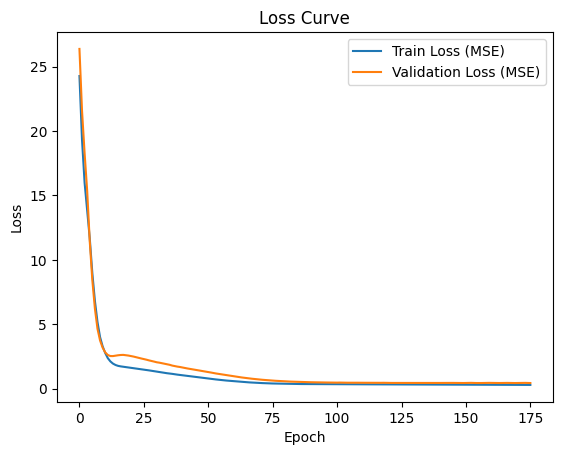

In [ ]:
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


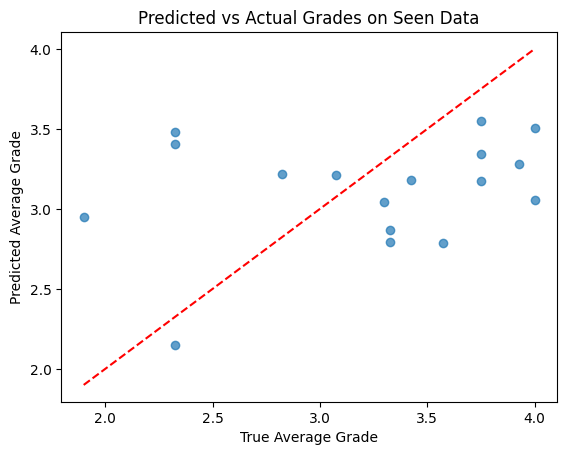

In [ ]:
y_pred = model.predict(X_test).flatten()
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('True Average Grade')
plt.ylabel('Predicted Average Grade')
plt.title('Predicted vs Actual Grades on Seen Data')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.show()


In [ ]:
df = pd.read_csv('preprocessed_model_data.csv')
print(df.head())

   Attendance_Encoded  StudyHours_Encoded  Assignments_Encoded  \
0               0.825                15.0                    3   
1               0.950                 5.0                    3   
2               0.450                 5.0                    1   
3               0.620                15.0                    2   
4               0.950                 5.0                    3   

   PartTimeJob_Encoded  Extracurriculars_Encoded  GPA_Normalized  \
0                    1                       0.5        0.190909   
1                    0                       1.0        0.518182   
2                    1                       0.0        0.476348   
3                    0                       1.0        0.609091   
4                    0                       0.0        0.476348   

   Average_Grade  
0       3.300000  
1       2.925000  
2       1.233333  
3       3.000000  
4       1.900000  


In [ ]:
features = [col for col in df.columns if col != 'Average_Grade']
target = 'Average_Grade'

X = df[features].values
y = df[target].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

In [ ]:
y_pred = model.predict(X_test).flatten()  # Makes prediction for each test sample


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [ ]:
# Define the numeric-to-letter grade conversion function
def numeric_to_letter_grade(avg_grade):
    if avg_grade >= 3.7:
        return 'A'
    elif avg_grade >= 3.3:
        return 'A-'
    elif avg_grade >= 3.0:
        return 'B+'
    elif avg_grade >= 2.7:
        return 'B'
    elif avg_grade >= 2.3:
        return 'B-'
    elif avg_grade >= 2.0:
        return 'C+'
    elif avg_grade >= 1.7:
        return 'C'
    elif avg_grade >= 1.3:
        return 'C-'
    elif avg_grade >= 1.0:
        return 'D+'
    elif avg_grade >= 0.7:
        return 'D'
    else:
        return 'E'

# Convert both actual and predicted numeric grades to letter grades
letter_preds = [numeric_to_letter_grade(x) for x in y_pred]
letter_actuals = [numeric_to_letter_grade(x) for x in y_test]

# Build and display/save the comparison table
import pandas as pd

results = pd.DataFrame({
    'Actual (Num)': y_test,
    'Actual (Letter)': letter_actuals,
    'Predicted (Num)': y_pred,
    'Predicted (Letter)': letter_preds
})

print(results.head())

   Actual (Num) Actual (Letter)  Predicted (Num) Predicted (Letter)
0         3.325              A-         2.867963                  B
1         3.575              A-         2.788435                  B
2         1.900               C         2.951446                  B
3         3.500              A-         3.376161                 A-
4         3.075              B+         2.518322                 B-


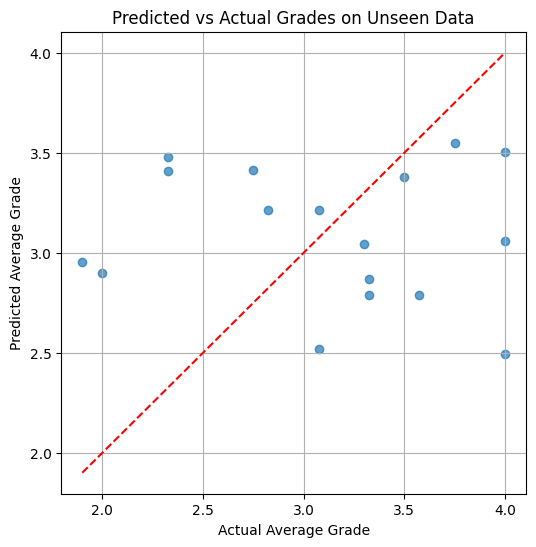

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual Average Grade')
plt.ylabel('Predicted Average Grade')
plt.title('Predicted vs Actual Grades on Unseen Data')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # reference line y=x
plt.grid(True)
plt.show()


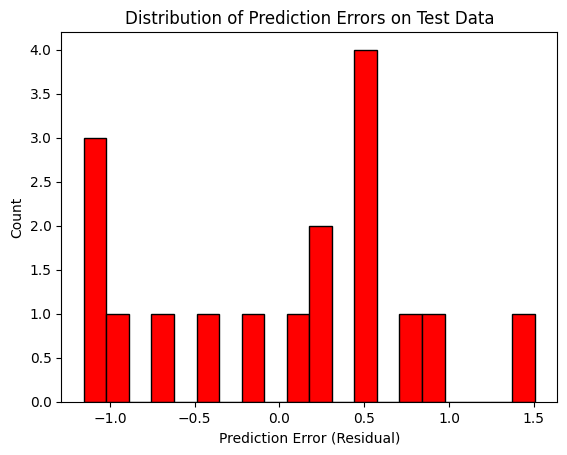

In [ ]:
residuals = y_test - y_pred
plt.figure()
plt.hist(residuals, bins=20, color='red', edgecolor='black')
plt.xlabel('Prediction Error (Residual)')
plt.ylabel('Count')
plt.title('Distribution of Prediction Errors on Test Data')
plt.show()


In [ ]:
# Save true and predicted values for further analysis
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results.to_csv('model_test_results.csv', index=False)


In [ ]:
import numpy as np

def predict_manual(model, gpa_scaler):
    # Prompt for specific attendance percentage
    while True:
        try:
            attendance_val = float(input("Enter your attendance percentage (e.g., 87.5 for 87.5%): "))
            break
        except ValueError:
            print("Please enter a valid number.\n")
    # Normalize attendance to the scale used for training, if needed
    # If you used percentage/100 as feature, then just divide by 100 here
    attendance_encoded = attendance_val / 100

    # Prompt for study hours
    while True:
        try:
            study_hours = float(input("Enter the number of study hours per week (e.g., 16): "))
            break
        except ValueError:
            print("Please enter a valid number.\n")

    # Prompt for assignment completion (as a number or percentage)
    while True:
        try:
            assignments = float(input("On average, what fraction of assignments do you submit on time? (e.g., 1 = 100%, 0.8 = 80%): "))
            break
        except ValueError:
            print("Please enter a value between 0 and 1, e.g., 0.8 for 80%.\n")

    # Part time job (yes/no)
    while True:
        job_raw = input("Are you currently doing a part time job? (yes/no): ").strip().lower()
        if job_raw == 'yes':
            job = 1
            break
        elif job_raw == 'no':
            job = 0
            break
        else:
            print("Please enter 'yes' or 'no'.\n")

    # Extracurricular activities
    while True:
        extra_raw = input("Are you involved in extracurricular activities? (yes/no/occasionally): ").strip().lower()
        if extra_raw == 'yes':
            extra = 1
            break
        elif extra_raw == 'no':
            extra = 0
            break
        elif extra_raw == 'occasionally':
            extra = 0.5
            break
        else:
            print("Please enter 'yes', 'no', or 'occasionally'.\n")

    # GPA (raw, then normalize)
    while True:
        try:
            gpa_raw = float(input("Enter your GPA (e.g., 3.25): ").strip())
            break
        except ValueError:
            print("Please enter a valid GPA number (e.g., 2.85, 3.14).\n")
    gpa_norm = gpa_scaler.transform([[gpa_raw]])[0][0]

    # Build feature array
    features_input = np.array([[attendance_encoded, study_hours, assignments, job, extra, gpa_norm]])

    pred = model.predict(features_input)[0][0]

    # Numeric to letter grade mapping
    def numeric_to_letter_grade(avg_grade):
        if avg_grade >= 3.7: return 'A'
        elif avg_grade >= 3.3: return 'A-'
        elif avg_grade >= 3.0: return 'B+'
        elif avg_grade >= 2.7: return 'B'
        elif avg_grade >= 2.3: return 'B-'
        elif avg_grade >= 2.0: return 'C+'
        elif avg_grade >= 1.7: return 'C'
        elif avg_grade >= 1.3: return 'C-'
        elif avg_grade >= 1.0: return 'D+'
        elif avg_grade >= 0.7: return 'D'
        else: return 'E'

    letter_grade = numeric_to_letter_grade(pred)
    print(f"\nPredicted Average Grade (numeric): {pred:.2f}")
    print(f"Predicted Average Grade (as letter): **{letter_grade}**")




In [ ]:
predict_manual(model, gpa_scaler)